In [1]:
%load_ext autoreload
%autoreload 2
# %matplotlib widget
%matplotlib inline

import itertools
import pandas
import csv
import torch
import numpy as np
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
# from allennlp.data.token_indexers.bert_tokenizers import PretrainedBertIndexer

from awesome_glue.task import Task
from awesome_glue.utils import AttackMetric
from awesome_glue.config import Config

from luna import ram_write, chunks
from allennlpx import allenutil
from openTSNE import TSNE as OTSNE
from openTSNE.callbacks import ErrorLogger

from adjustText import adjust_text
from luna import ram_read

from allennlpx.interpret.attackers.embedding_searcher import EmbeddingSearcher

from collections import Counter, defaultdict
from tqdm import tqdm

In [2]:
config = Config()
# config.finetunable=True
task = Task(config) # type: Task
task.from_pretrained()
config

cache for SST-bert exists
*** load SST-bert from cache cost 3.43 seconds
Restore model from checkpoint saved/models/SST-bert-fix@0.ckpt.


Basic Args:
	--task_id=SST
	--finetunable=False
	--arch=bert
	--pretrain=fasttext
	--mode=attack
	--attack_vectors=glove
	--attack_tsv=nogit/SST-bert-fix.attack.tsv
	--alchemist=False
	--seed=2
Deduced Args:
	--model_name=SST-bert-fix
	--tokenizer=bert

In [105]:
# next(zip(*list(task.model.named_parameters())))

In [5]:
@torch.no_grad()
def get_internals(sent='hello world', inc=False):
    sent = sent.split(" ")
    inc_sents = []
    if inc:
        for ti in range(1, len(sent) + 1):
            inc_sents.append({"sentence": allenutil.as_sentence(sent[:ti])})
    else:
        inc_sents.append({"sentence": allenutil.as_sentence(sent)})
    sent_embeds = []
    sent_preds = []
    with task.predictor.capture_named_internals(tgt_module) as internals:
        outputs = task.predictor.predict_batch_json(inc_sents)
        if config.pretrain=='bert':
            sent_embeds.append(internals[tgt_module][:, 0]) # GET [CLS]
        else:
            sent_embeds.append(internals[tgt_module])
    for i, ele in enumerate(outputs):
        sent_preds.append(ele['probs'][idx_1] > ele['probs'][idx_0])
    sent_embeds = torch.cat(sent_embeds, dim=0)
    return sent_embeds, sent_preds

In [4]:
class TSNEPlotter:
    def __init__(self, embeds: np.ndarray, mask, base_num: int, annotations):
        self.embeds = embeds
        self.mask = mask
        self.base_num = base_num
        otsne = OTSNE(initialization='pca', 
                      negative_gradient_method='bh',
                      callbacks=ErrorLogger())
        self.points = otsne.fit(self.embeds)
        self.annotations = annotations
        
    def plot(self):
        plt.rcParams['figure.figsize'] = [5, 5]
        bases = self.points[:self.base_num]
        pos_mask = np.array(self.mask[:self.base_num])
        plt.scatter(bases[:, 0][pos_mask], bases[:, 1][pos_mask], c='#00FF0020', label='pos', marker='+')
        plt.scatter(bases[:, 0][~pos_mask], bases[:, 1][~pos_mask], c='#FF000020', label='neg', marker='+')   
        
        news = self.points[self.base_num:]
        pos_mask = self.mask[self.base_num:]
        texts = []
        for idx in range(news.shape[0]):
            plt.scatter(news[idx, 0], news[idx, 1], c='g' if pos_mask[idx] else 'r', marker='x', s=10)
            texts.append(plt.text(news[idx, 0], news[idx, 1], 
                                  self.annotations[idx], 
                                  ha='center', va='center'))
        adjust_text(texts)
        plt.legend()
    

Encountered the loss key in the model's return dictionary which couldn't be split by the batch size. Key will be ignored.


In [3]:
task.transfer_attack()

Restore model from checkpoint saved/models/SST-bert-fix@0.ckpt.
Accu before: 93.00%, after: 47.00%, Flip ratio 49.46%


In [28]:
outputs = task.predictor.predict_batch_instance(task.train_data[:100])

In [10]:
if config.arch == 'bert':
    trunc_train_data = list(filter(lambda x: len(x['berty_tokens']) > 25, task.train_data))
else:
    trunc_train_data = list(filter(lambda x: len(x['sent']) > 10, task.train_data))
print(len(trunc_train_data))    

with torch.no_grad():
    train_embeds = defaultdict(lambda: [])
    train_labels = []
    for instances in tqdm(chunks(trunc_train_data, 300)):
        outputs = task.predictor.predict_batch_instance(instances)
#         train_embeds.append(ram_read("bert_layers")[:, 2])
        if config.arch == 'bert':
            for lid in [2, 5, 8, 10, 11]:
                train_embeds[lid].append(ram_read("bert_layers")[lid][:, 0].detach())
        for instance in instances:
            train_labels.append(instance.fields['label'].label)
        torch.cuda.empty_cache()
    if config.arch == 'bert':
        for lid in [2, 5, 8, 10, 11]:   
            train_embeds[lid] = torch.cat(train_embeds[lid], dim=0)
            torch.cuda.empty_cache()
print("Load all train embeds")

0it [00:00, ?it/s]

6494


22it [00:13,  1.63it/s]

Load all train embeds


In [12]:
idx_0 = 0
idx_1 = 1

layer_idx = 9
k_num = 20
    
# task.predictor.predict("Steers turns in a snappy screenplay that curls at the edges ; it 's so clever you want to hate it .")
# state = ram_read("state")[:, 0]
searcher = EmbeddingSearcher(embed=train_embeds[layer_idx], word2idx=None, idx2word=lambda x: train_labels[x])
    
df = pandas.read_csv(config.attack_tsv, sep='\t', quoting=csv.QUOTE_NONE)
attack_metric = AttackMetric()
for rid in range(0, df.shape[0]):
    label = df.iloc[rid]['label']
    
    task.predictor.predict(df.iloc[rid]['raw'])
#     raw_state = ram_read("bert_layers")[0, 2]
    raw_state = ram_read("bert_layers")[layer_idx][:, 0]
    tk_vals, tk_idxs = searcher.find_neighbours(raw_state, 'euc', topk=k_num)
    raw_label = Counter([train_labels[idx] for idx in tk_idxs]).most_common(1)[0][0]

    task.predictor.predict(df.iloc[rid]['att'])
#     att_state = ram_read("bert_layers")[0, 2]
    att_state  = ram_read("bert_layers")[layer_idx][:, 0]
    tk_vals, tk_idxs = searcher.find_neighbours(att_state, 'euc', topk=k_num)
    att_label = Counter([train_labels[idx] for idx in tk_idxs]).most_common(1)[0][0]
    
    attack_metric.count_label(label, raw_label, att_label)
print(attack_metric)

Accu before: 84.00%, after: 60.00%, Flip ratio 28.57%


In [26]:
Accu before: 63.00%, after: 51.00%, Flip ratio 19.05%
Accu before: 66.00%, after: 53.00%, Flip ratio 19.70%
Accu before: 72.00%, after: 55.00%, Flip ratio 23.61%
Accu before: 86.00%, after: 62.00%, Flip ratio 27.91%
Accu before: 92.00%, after: 61.00%, Flip ratio 33.70%


Basic Args:
	--task_id=SST
	--finetunable=True
	--arch=bert
	--pretrain=fasttext
	--mode=attack
	--attack_vectors=glove
	--attack_tsv=nogit/SST-bert.attack.tsv
	--alchemist=False
	--seed=2
Deduced Args:
	--model_name=SST-bert
	--tokenizer=bert

Iteration   50, KL divergence  2.3234, 50 iterations in 0.2220 sec
Iteration  100, KL divergence  2.2599, 50 iterations in 0.1974 sec
Iteration  150, KL divergence  2.2459, 50 iterations in 0.2367 sec
Iteration  200, KL divergence  2.2393, 50 iterations in 0.2021 sec
Iteration  250, KL divergence  2.2366, 50 iterations in 0.1851 sec
Iteration   50, KL divergence  0.8437, 50 iterations in 0.2267 sec
Iteration  100, KL divergence  0.6904, 50 iterations in 0.2905 sec
Iteration  150, KL divergence  0.6299, 50 iterations in 0.2885 sec
Iteration  200, KL divergence  0.6035, 50 iterations in 0.2535 sec
Iteration  250, KL divergence  0.5912, 50 iterations in 0.1957 sec
Iteration  300, KL divergence  0.5842, 50 iterations in 0.2323 sec
Iteration  350, KL divergence  0.5791, 50 iterations in 0.1755 sec
Iteration  400, KL divergence  0.5764, 50 iterations in 0.1986 sec
Iteration  450, KL divergence  0.5744, 50 iterations in 0.1476 sec
Iteration  500, KL divergence  0.5729, 50 iterations in 0.1785

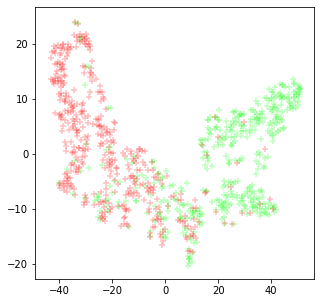

In [22]:
idx_0 = 0
idx_1 = 1

if config.pretrain == 'bert':
#     tgt_module = "word_embedders.token_embedder_tokens.bert_model.pooler.activation"
    tgt_module = "word_embedders.token_embedder_tokens.bert_model.encoder.layer.11"
else:
    tgt_module = "encoder"

with torch.no_grad():
    sst_embeds = []
    sst_preds = []
    sst_labels = []
    for instances in chunks(task.dev_data, 300):
#         with task.predictor.capture_named_internals(tgt_module) as internals:
#             outputs = task.predictor.predict_batch_instance(instances)
#             if config.pretrain == 'bert':
#                 sst_embeds.append(internals[tgt_module][:, 0]) # GET [CLS]
#             else:
#                 sst_embeds.append(internals[tgt_module])
        outputs = task.predictor.predict_batch_instance(instances)
        sst_embeds.append(ram_read("state")[:, 1])
        
        for i, ele in enumerate(outputs):
            sst_preds.append(ele['probs'][idx_1] > ele['probs'][idx_0])
        for instance in instances:
            sst_labels.append(instance.fields['label'].label == idx_1)
    sst_embeds = torch.cat(sst_embeds, dim=0)
torch.cuda.empty_cache()
# sst_embeds.size()
otsne = OTSNE(initialization='pca', negative_gradient_method='bh', callbacks=ErrorLogger())
sst2ds = otsne.fit(sst_embeds.cpu().numpy())
plt.rcParams['figure.figsize'] = [5, 5]
plt.scatter(sst2ds[:, 0][np.array(sst_labels)], sst2ds[:, 1][np.array(sst_labels)], c='#00FF0040', label='pos', marker='+')
plt.scatter(sst2ds[:, 0][~np.array(sst_labels)], sst2ds[:, 1][~np.array(sst_labels)], c='#FF000040', label='neg', marker='+')


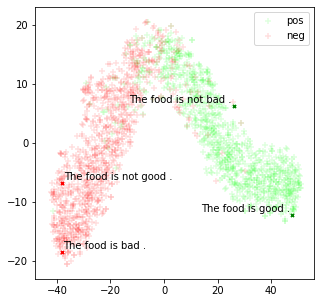

In [74]:
# allenutil.as_sentence(instance)
mysents = [
    "The food is good .",
    "The food is bad .",
    "The food is not good .",
    "The food is not bad .",    
]
my_embeds = []
my_preds = []
for sent in mysents:
    embed, pred = get_internals(sent)
    my_embeds.append(embed)
    my_preds.extend(pred)
my_embeds = torch.cat(my_embeds, dim=0)

all_embeds = np.concatenate([sst_embeds.cpu().numpy(), my_embeds.cpu().numpy()])

plotter = TSNEPlotter(all_embeds, 
                      mask = sst_labels + my_preds,
                      base_num =sst_embeds.shape[0], 
                      annotations=mysents
#                       annotations=[str(idx) for idx in range(len(mysents))]
                     )
plotter.plot()


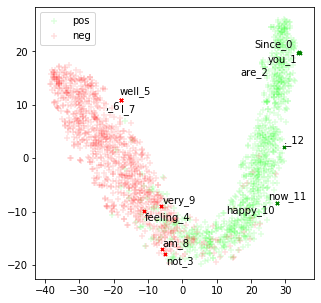

In [42]:
# allenutil.as_sentence(instance)
mysents = ["Since you are not feeling well , I am very happy now ."]
annots = [f"{ele}_{i}" for sent in mysents for i, ele in enumerate(sent.split(" "))]
my_embeds = []
my_preds = []
for sent in mysents:
    embed, pred = get_internals(sent, inc=True)
    my_embeds.append(embed)
    my_preds.extend(pred)
my_embeds = torch.cat(my_embeds, dim=0)

all_embeds = np.concatenate([sst_embeds.cpu().numpy(), my_embeds.cpu().numpy()])

plotter = TSNEPlotter(all_embeds, 
                      mask = sst_labels + my_preds,
                      base_num =sst_embeds.shape[0], 
                      annotations=annots
#                       annotations=[str(idx) for idx in range(len(mysents))]
                     )
plotter.plot()